In [79]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))


# Load your dataset
df = pd.read_csv("full_data_fusionne.csv")

# Drop rows where title is missing
df = df.dropna(subset=['title'])

# Ensure titles are strings
df['title'] = df['title'].astype(str)

# Function to clean Arabic text
def remove_arabic_stopwords(text):
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in arabic_stopwords])

# Apply the function to the 'title' column
df['title'] = df['title'].apply(remove_arabic_stopwords)

# Preview the result
print(df['title'].head())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    الألعاب الأولمبية : الملاكمة خليف تبلغ ربع الن...
1    محطة أفريقيا الألعاب الأولمبية بباريس : `` خيم...
2    تنديدا باغتيال هنية ... مظاهرات مناهضة لإسرائي...
3    إسرائيل `` تغتال '' صحفيا ومصورا قناة الجزيرة ...
4    خليل الحية اغتيال هنية .. جريمة بد لمرتكبها يد...
Name: title, dtype: object


In [81]:
# 📌 Step 2: Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
from farasa.segmenter import FarasaSegmenter
import matplotlib.pyplot as plt

In [83]:
# 📌 Step 3: Load Dataset
#df = pd.read_csv('full_data_fusionne.csv')
df = df.dropna(subset=['title'])  # Remove rows with missing titles
titles = df['title'].astype(str).tolist()

In [85]:
# 📌 Step 4: Arabic Preprocessing
segmenter = FarasaSegmenter(interactive=True)

def preprocess_arabic(text):
    return segmenter.segment(text)

titles_preprocessed = [preprocess_arabic(t) for t in tqdm(titles)]

[2025-04-07 02:36:32,294 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
100%|███████████████████████████████████████████████████████████████████████████| 41554/41554 [01:02<00:00, 664.70it/s]


In [87]:
# 📌 Step 5: Load BERT Model & Tokenizer
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(64000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [89]:
# 📌 Step 6: Generate Embeddings
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

embeddings = np.array([get_cls_embedding(t) for t in tqdm(titles_preprocessed)])

100%|██████████████████████████████████████████████████████████████████████████| 41554/41554 [2:13:28<00:00,  5.19it/s]


In [90]:
# 📌 Step 7: KMeans Clustering
n_clusters = 5  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

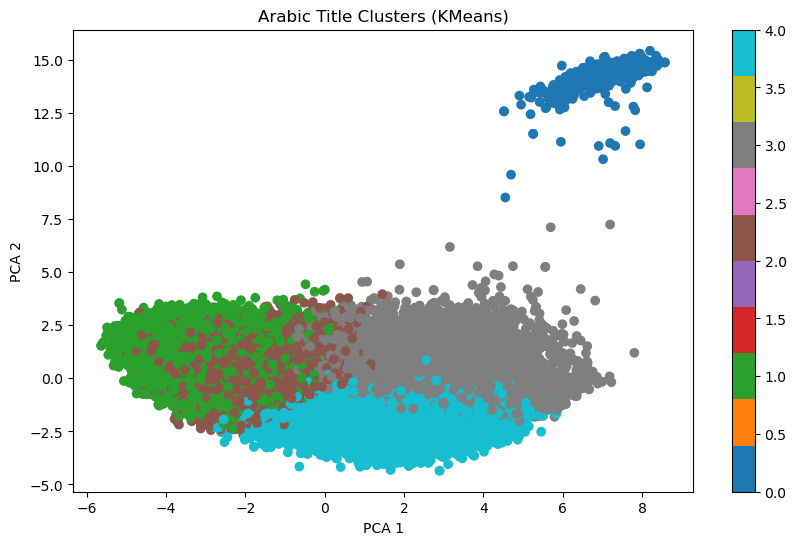

In [91]:
# 📌 Step 8: (Optional) Visualization with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='tab10')
plt.title("Arabic Title Clusters (KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()

In [92]:
# 📌 Step 9: View Example Titles in Each Cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['title'].head(5).to_string(index=False))


Cluster 0:
    وصول نعش إسماعيل هنية الدوحة جنازة حاشدة إيران
   إسرائيل تعلن البدء بتنفيذ عملية برية جنوب لبنان
غارات جوية وعمليات برية إسرائيلية قطاع غزة توقع...
                فرنسا : دقت ساعة النهاية لبارنييه؟
         الأطفال يبدؤون عاما دراسيا جديدا أوكرانيا

Cluster 1:
الألعاب الأولمبية : الملاكمة خليف تبلغ ربع النه...
محطة أفريقيا الألعاب الأولمبية بباريس : `` خيمة...
إسرائيل `` تغتال '' صحفيا ومصورا قناة الجزيرة ق...
إجراءات أمنية مشددة إسرائيل تحسبا لسيناريوهات م...
تبادل عدة سجناء روسيا وعدة دول غربية بينهم الصح...

Cluster 2:
تنديدا باغتيال هنية ... مظاهرات مناهضة لإسرائيل...
اغتيال إسماعيل هنية .. واشنطن تنفي تورطها وقلق ...
             سيرد `` محور المقاومة '' اغتيال هنية؟
العقل المدبر لاعتداءات 11 خالد شيخ محمد ينجو ال...
تشييع رسمي وشعبي لإسماعيل هنية رئيس المكتب السي...

Cluster 3:
     أولمبياد باريس 2024 : تقنيات لمنع هطول المطر؟
حزب الله يؤكد مقتل فؤاد شكر بضربة إسرائيلية وخط...
        قصف مدفعي كثيف وغارات إسرائيلية جنوب لبنان
          أبرز ردود الفعل الهجوم ا

In [93]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings, df['cluster'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0623


In [94]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, preds)
    print(f"k={k} --> Silhouette Score: {score:.4f}")


k=2 --> Silhouette Score: 0.0753
k=3 --> Silhouette Score: 0.0525
k=4 --> Silhouette Score: 0.0500
k=5 --> Silhouette Score: 0.0623
k=6 --> Silhouette Score: 0.0601
k=7 --> Silhouette Score: 0.0631
k=8 --> Silhouette Score: 0.0605
k=9 --> Silhouette Score: 0.0589
k=10 --> Silhouette Score: 0.0583


In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_pca)

sil_score = silhouette_score(embeddings_pca, df['cluster'])
print(f"Silhouette Score after PCA: {sil_score:.4f}")


Silhouette Score after PCA: 0.0931


In [111]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, metric='euclidean')
df['cluster_hdbscan'] = clusterer.fit_predict(embeddings_pca)

# Check number of clusters found
print(f"HDBSCAN found {df['cluster_hdbscan'].nunique()} clusters")

# Silhouette Score (only for non-outliers)
mask = df['cluster_hdbscan'] != -1
print("Silhouette Score (HDBSCAN):", silhouette_score(embeddings_pca[mask], df['cluster_hdbscan'][mask]))


HDBSCAN found 3 clusters
Silhouette Score (HDBSCAN): 0.5725296


In [115]:
for i in sorted(df['cluster_hdbscan'].unique()):
    if i == -1:
        print(f"\nCluster -1 (outliers):")
    else:
        print(f"\nCluster {i}:")
    print(df[df['cluster_hdbscan'] == i]['title'].head(5).to_string(index=False))



Cluster -1 (outliers):
    وصول نعش إسماعيل هنية الدوحة جنازة حاشدة إيران
إسرائيل تصدر أوامر إخلاء جديدة بشمال قطاع غزة و...
 حكومة نتنياهو توافق توسيع المستوطنات هضبة الجولان
                  غارات إسرائيلية جديدة صور وبعلبك
                  تعثر التفاوض يبعثر أوراق الوساطة

Cluster 0:
الألعاب الأولمبية : الملاكمة خليف تبلغ ربع النه...
محطة أفريقيا الألعاب الأولمبية بباريس : `` خيمة...
تنديدا باغتيال هنية ... مظاهرات مناهضة لإسرائيل...
إسرائيل `` تغتال '' صحفيا ومصورا قناة الجزيرة ق...
خليل الحية اغتيال هنية .. جريمة بد لمرتكبها يدف...

Cluster 1:
   إسرائيل تعلن البدء بتنفيذ عملية برية جنوب لبنان
غارات جوية وعمليات برية إسرائيلية قطاع غزة توقع...
                فرنسا : دقت ساعة النهاية لبارنييه؟
         الأطفال يبدؤون عاما دراسيا جديدا أوكرانيا
                          غزة : تبددت آمال الهدنة؟


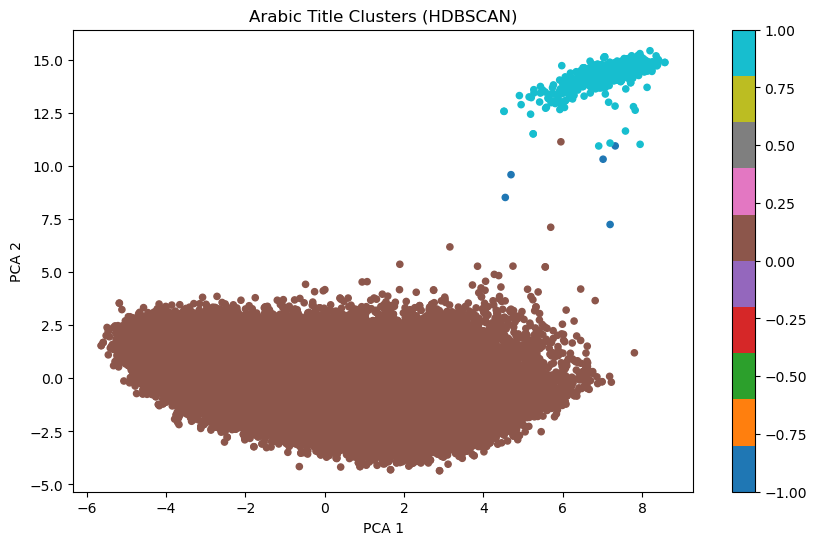

In [117]:
plt.figure(figsize=(10, 6))
colors = df['cluster_hdbscan']
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors, cmap='tab10', s=20)
plt.title("Arabic Title Clusters (HDBSCAN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter)
plt.show()


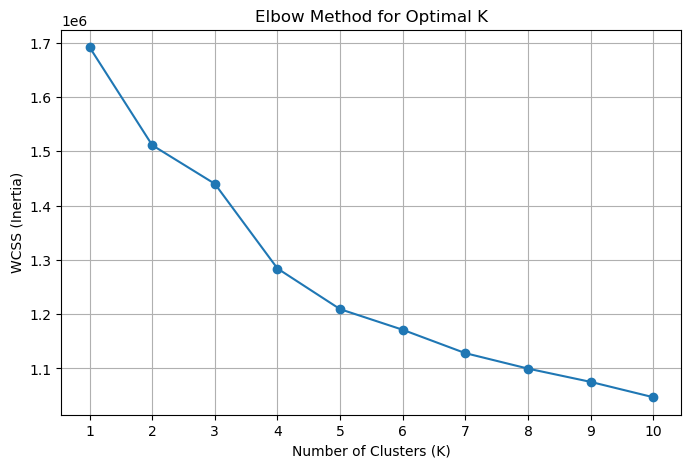

In [109]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_pca)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.grid(True)
plt.xticks(K_range)
plt.show()


In [127]:
df['cluster_hdbscan'].value_counts().to_dict()

{0: 41087, 1: 462, -1: 5}